# Rigorous splitting of datasets into train and validation

In this lab we will try our hand at protein structure prediction. Given a few thousands protein sequences, for each of the amino acids in the sequences we will try to predict if in the protein structure they will be part of one of three classes:

* $\alpha$-helix
* $\beta$-sheet
* none of the above
<img src="https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/blob/master/session_goodPracticesDatasetDesign/lab_validation/figures/secondary_structure.png?0=&raw=1">

So the input to our predictor is a protein sequence string such as this one:

```
>APF29063.1 spike protein [Human coronavirus NL63]
MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGN
HRSAFALHTGYYDVNQYYIYVTNEIGLNASVTLKICKFGINTTFDFLSNSSSSFDCIVNLLFTEQLGAPL
```

for each letter in the sequence, we want to make a classification in the three classes mentioned above.

I have prepared a dataset where all protein sequences have been pre-split into windows of 31 amino acids. We want to predict the class for the amino acid in the center of the window, like so:


predict("MKLFLILLVLPLASCF<font color="red">F</font>TCNSNANLSMLQLG") -> [p(H), p(S), p(C)]

Of course, a neural network will not accept a string input as it is, so we will have to deal with this by converting each letter in our alphabet into an integer. Then, we will use word embeddings to translate the integers into vectors of floating points.


## To work on google colab

[Click on this link](https://colab.research.google.com/github/NBISweden/workshop-neural-nets-and-deep-learning/blob/master/session_goodPracticesDatasetDesign/lab_validation/rigorous_train_validation_splitting.ipynb)

## Data download

First, let's setup the colab environment, download dataset and other relevant data:

In [6]:
#Uncomment this code in google colab to checkout the course repository and unzip the data

#%cd /content
# !git clone https://github.com/NBISweden/workshop-neural-nets-and-deep-learning.git
%cd /content/workshop-neural-nets-and-deep-learning/session_goodPracticesDatasetDesign/lab_validation
# !wget -v -O data/dataset_sseq_singleseq.pic -L   https://liu.box.com/shared/static/egutdq7rb5q3gaiu0fbjy9csl28ogpo9
# !wget -v -O data/trainset_distance_matrix.tsv -L https://liu.box.com/shared/static/xbgslccvlbosodtd585n7nh7s6hpmjoz

fatal: destination path 'workshop-neural-nets-and-deep-learning' already exists and is not an empty directory.
/content/workshop-neural-nets-and-deep-learning/session_goodPracticesDatasetDesign/lab_validation
--2024-05-23 09:06:46--  https://liu.box.com/shared/static/egutdq7rb5q3gaiu0fbjy9csl28ogpo9
Resolving liu.box.com (liu.box.com)... 74.112.186.144
Connecting to liu.box.com (liu.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/egutdq7rb5q3gaiu0fbjy9csl28ogpo9 [following]
--2024-05-23 09:06:46--  https://liu.box.com/public/static/egutdq7rb5q3gaiu0fbjy9csl28ogpo9
Reusing existing connection to liu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://liu.app.box.com/public/static/egutdq7rb5q3gaiu0fbjy9csl28ogpo9 [following]
--2024-05-23 09:06:46--  https://liu.app.box.com/public/static/egutdq7rb5q3gaiu0fbjy9csl28ogpo9
Resolving liu.app.box.com (liu.app.box.com)... 7

In [7]:
pwd

'/content/workshop-neural-nets-and-deep-learning/session_goodPracticesDatasetDesign/lab_validation'

Now let's load libraries and plotting functions:

In [8]:
# On MacOsx, if you experience dying kernel when
# running `model_sseq2.fit` you might want to uncomment
# the following lines
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import h5py
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, LSTM, Conv1D, Bidirectional
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt

def plot_loss_acc(history):
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim([0.4, 1.0])
    plt.legend(['train acc', 'val acc', 'train loss', 'val loss'], loc='upper left')
    plt.show()

Now let's create a function that returns a keras model. Modify the code below to try different architectures:

In [2]:
import keras

def get_model(convolutional = False, window=31):# This switches between a convolutional or a recurrent architecture
    embed_size = 64
    bidir_size = 32

    model = Sequential()
    model.add(Embedding(21, embed_size, input_shape=(window,)))

    if convolutional:
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(Conv1D(16, 5, activation='relu'))
        model.add(Conv1D(8, 3, activation='relu'))
    else:
        model.add(Bidirectional(LSTM(bidir_size, return_sequences=True)))

    model.add(Flatten())
    model.add(Dense(16))
    model.add(Dense(3, activation='softmax'))

    #MODEL
    print('Compiling the model...')
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    model.summary()

    return model

Look at the architecture above:
* What does putting the variable "convolutional" to False mean? What happens to the bidirectional layers when we are using a convolutional architecture?
* Which architecture would be best for this type of dataset in your opinion?
    

In [3]:
def count_steps(target_list_data, batch=None):

    n_targets = len(target_list_data)

    target_index = 0
    n_steps = 0
    for target in target_list_data:

        try:
            X_batch = X[target]
            #print(X_batch.shape)
        except:
            continue

        length = X_batch.shape[0]

        n_steps += int(length / batch)
    return n_steps

def generate_inputs_window(X, y, target_list_data, batch=None, shuffle=False):

    n_targets = len(target_list_data)
    if shuffle:
        random.shuffle(target_list_data)

    target_index = 0
    while 1:

        target = target_list_data[target_index]
        target_index += 1
        target_index = target_index % n_targets

        # create numpy arrays of input data
        # and labels, from each line in the file
        try:
            X_batch = X[target]
        except:
            continue

        length = X_batch.shape[0]
                                        # 0...00length00...0, max_depth

        labels_batch_sseq = y[target]

       # print(np.array(X_batch_windows).shape)

        for i in range(0, length, batch):
            # length x 1 (sparse, 3 class)
            yield (X_batch[i:i+batch], labels_batch_sseq[i:i+batch])


Now let's load the dataset as a pickle object:

In [9]:
import pickle
(X,y) = pickle.load(open("data/dataset_sseq_singleseq.pic",'rb'))

In [51]:
# print(X['1A17A\n'][[0,5]])
print(X['4YBAB\n'],'\n')
print(y['4YBAB\n'])


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8
  18  2 11  3  5 10  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18
   2 11  3  5 10  3 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2
  11  3  5 10  3 17 19]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2 11
   3  5 10  3 17 19  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2 11  3
   5 10  3 17 19  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2 11  3  5
  10  3 17 19  6  6 17]
 [ 0  0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2 11  3  5 10
   3 17 19  6  6 17 20]
 [ 0  0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2 11  3  5 10  3
  17 19  6  6 17 20  9]
 [ 0  0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2 11  3  5 10  3 17
  19  6  6 17 20  9 11]
 [ 0  0  0  0  0  0  6 12 18 11  6 16 20  1  8 18  2 11  3  5 10  3 17 19
   6  6 17 20  9 11  8]
 [ 0  0  0  0  0  6 

Ok, let's start by taking the classical approach of randomly splitting the data in a trainset and a validation set (95%/5% by default, but you can change the ratio as you prefer).

In [27]:
import random

input_dataset = 'data/dataset_sseq_singleseq.hdf5'
target_list_path = 'data/train_set'
batch = 256

target_list_file = open(target_list_path)
target_list = target_list_file.readlines()
random.shuffle(target_list)
n_targets = len(target_list)
train_list = target_list[int(n_targets/20):] #95% train
validation_list = target_list[:int(n_targets/20)] #5% validation

train_steps = count_steps(train_list, batch)
validation_steps = count_steps(validation_list, batch)
print("Validation batches:", validation_steps)

Validation batches: 192


In [43]:
validation_list[-3:]

['3G9AB\n', '4YBAB\n', '3L09A\n']

Don't run the following hidden cell if you don't want to spend a long time waiting for the data!

In [ ]:
#DON'T RUN THIS DURING A LAB
#from keras.utils.io_utils import HDF5Matrix
#def load_inputs(target_list_data, shuffle=False):
#
#    X = {}
#    y = {}
#
#    n_targets = len(target_list_data)
#    if shuffle:
#        random.shuffle(target_list_data)
#
#    target_index = 0
#
#    for target_index in range(n_targets):
#
#        target = target_list_data[target_index]
#
#        try:
#            X_batch = np.asarray(HDF5Matrix(input_dataset, 'inputs_windows/' + target))  # length x max_depth
#        except:
#            continue
#
#        length = X_batch.shape[0]
#                                        # 0...00length00...0, max_depth
#
#        X[target] = X_batch
#        y[target] = np.squeeze(np.asarray(HDF5Matrix(input_dataset, 'labels_sseq/' + target)))
#    return X, y
#
#train_test_data = open("data/train_test_set", 'r').readlines()
#X,y = load_inputs(train_test_data)
#
#import pickle
#pickle.dump((X,y), open("data/dataset_sseq_singleseq.pic", 'wb'))
#
#

And now, let's train the model a first time (train and validation split randomly):

In [29]:
model_sseq = get_model(convolutional=True) #get a fresh model
hist = model_sseq.fit(generate_inputs_window(X,y,train_list, batch),
               validation_data=generate_inputs_window(X,y,validation_list, batch),
               epochs=7, steps_per_epoch=train_steps, validation_steps=validation_steps)


Compiling the model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 64)            1344      
                                                                 
 conv1d_3 (Conv1D)           (None, 25, 32)            14368     
                                                                 
 conv1d_4 (Conv1D)           (None, 21, 16)            2576      
                                                                 
 conv1d_5 (Conv1D)           (None, 19, 8)             392       
                                                                 
 flatten_2 (Flatten)         (None, 152)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                2448      
                                                                 
 dense_5 (Dense)             (N

Let's plot the training curves below:

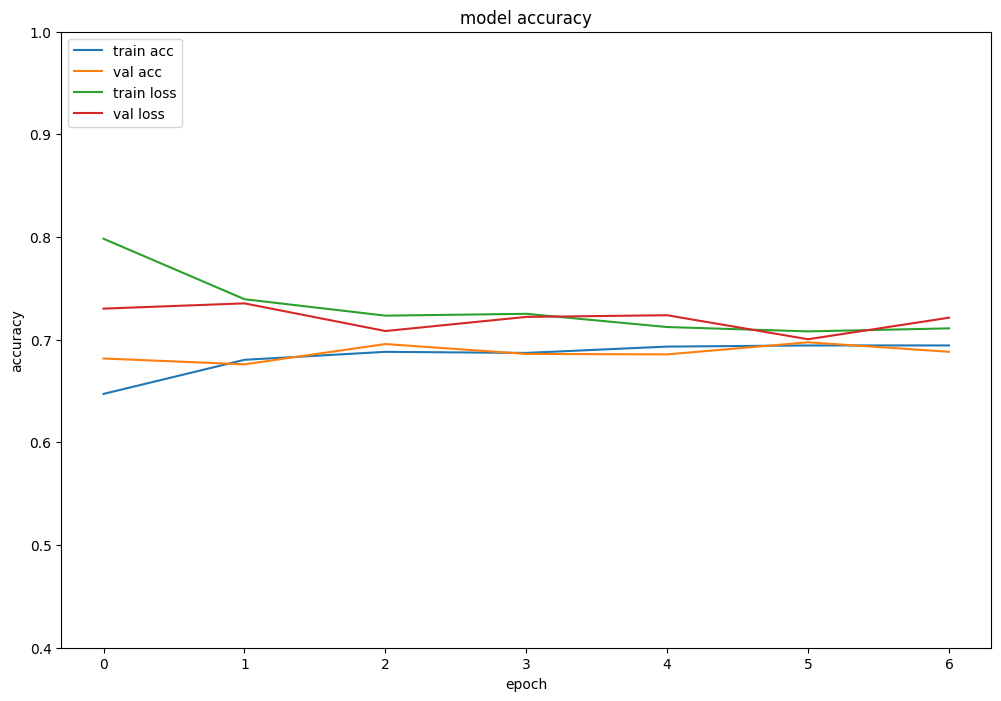

In [30]:
plot_loss_acc(hist)

* What is the best validation performance that you can extract from your Model?
* What would be the best naïve classifier for this dataset? How does the validation performance of your model compare to it?
* What do you think of randomly splitting the dataset this way? Can you think of a better way of doing it? Can you think of a _worse_ day of doing it?

## Splitting the dataset by sequence similarity

I have used HHblits (a software to perform sequence alignments) to find out just how distant the proteins in the dataset are, evolutionarily speaking. This distance goes from 0 (sequences are identical) to 1 (no relationship between the proteins could be detected at all). The distance is basically an inverse measure of how similar the sequences are to each other.

This information is stored in a distance matrix of size NxN, where N is the number of sequences in the dataset. In the code block below I load the distance matrix from the filesystem, then we use the data to perform [linkage clustering](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) and plot a [dendrogram](https://en.wikipedia.org/wiki/Dendrogram) to visualize the clusters.

In the dendrogram below we can see how proteins group together at various distance thresholds.

In [18]:
sys.setrecursionlimit(100000) #fixes issue with scipy and recursion limit
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
distance_matrix = pd.read_csv('data/trainset_distance_matrix.tsv', sep='\t')
dists = squareform(distance_matrix)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, color_threshold=0.8)
plt.show()

Below, we choose a threshold to get our cluster based on the distance threshold t. So we "cut" the dendrogram above at the threshold t, and all the proteins that fall under the same branch at that threshold will be put in the same cluster. Feel free to get a feeling of how clusters are formed/split by varying the threshold below:

In [19]:
cluster_assignments = fcluster(linkage_matrix,criterion='distance', t=0.8)
print(len(cluster_assignments), np.max(cluster_assignments))

6546 2449


Now let's create a training and a validation set based on these clusters in such a way that a cluster of protein is EITHER in train OR in validation. Depending on the threshold we have picked, this could make sure that no proteins in the validation set are too similar to those in the trainset.

In [20]:
target_list_file = open(target_list_path)
target_list = target_list_file.readlines()

train_list_cluster = []
validation_list_cluster = []
validation_size_limit = int(n_targets/20)

for i in range(1,np.max(cluster_assignments)+1):
    index_this_cluster = np.where(cluster_assignments == i)[0]
    if len(validation_list_cluster) < validation_size_limit: #add all elements in this cluster to either validation or train set
        validation_list_cluster += [target_list[element] for element in index_this_cluster]
    else:
        train_list_cluster += [target_list[element] for element in index_this_cluster]

random.shuffle(train_list_cluster)
validation_steps_cluster = count_steps(validation_list_cluster, batch)
print("Validation batches:", validation_steps_cluster)

Validation batches: 375


Now, let's train a new model with the new datasets and see if we get different results:

In [21]:
model_sseq2 = get_model(convolutional=False) #get a fresh model

hist2 = model_sseq2.fit(generate_inputs_window(X,y,train_list_cluster, batch),
               validation_data=generate_inputs_window(X,y,validation_list_cluster, batch),
               epochs=10, steps_per_epoch=1000, validation_steps=validation_steps_cluster)


Compiling the model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 64)            1344      
                                                                 
 bidirectional (Bidirection  (None, 31, 64)            24832     
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1984)              0         
                                                                 
 dense (Dense)               (None, 16)                31760     
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 57987 (226.51 KB)
Trainable params: 57987 (226.51 KB)
Non-trainable params: 0 (0.00 B

Let's plot again the training curves from the first model and compare them to those from the new model.

What are the differences, if any?

In [ ]:
plot_loss_acc(hist)

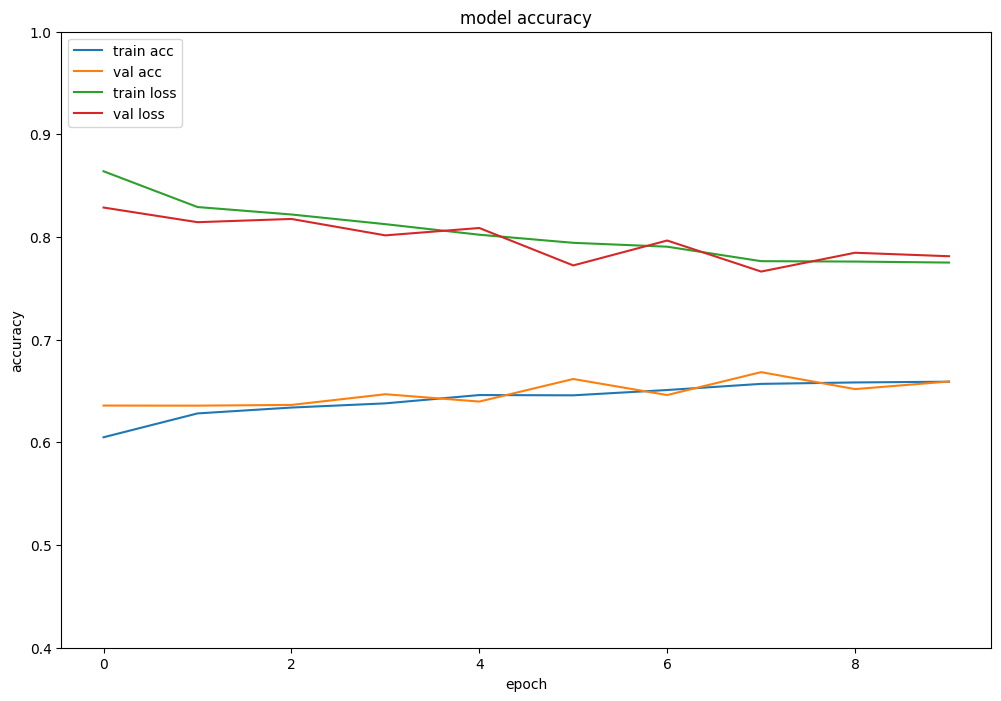

In [22]:
plot_loss_acc(hist2)

Now let's test the two models on previously unseen data. Which performs best?

In [33]:
test_list = open("data/test_set").readlines()
test_steps = count_steps(test_list, batch)
print("Test steps:", test_steps)
res1 = model_sseq.evaluate(generate_inputs_window(X,y,test_list, batch), verbose=1, steps=test_steps)
res2 = model_sseq2.evaluate(generate_inputs_window(X,y,test_list, batch), verbose=1, steps=test_steps)
print(f"Model 1 test accuracy: {res1[1]}")
print(f"Model 2 test accuracy: {res2[1]}")

Test steps: 97
97/97 [==============================] - 3s 29ms/step - loss: 0.8314 - sparse_categorical_accuracy: 0.6209
Model 1 test accuracy: 0.6481796503067017
Model 2 test accuracy: 0.6209402680397034


## If you have extra time and want to play more with the data

Now let's make things even worse on purpose: whenever a cluster contains more than one sample, let's put half in the training set and half in the validation set. Then let's not shuffle the trainset so that the network sees those samples first.

In [34]:
target_list_file = open(target_list_path)
target_list = target_list_file.readlines()

train_list_bad = []
validation_list_bad = []
validation_size_limit = int(n_targets/20)

for i in range(1,np.max(cluster_assignments)+1):
    index_this_cluster = np.where(cluster_assignments == i)[0]

    if len(index_this_cluster) > 1: #add all elements in this cluster to either validation or train set
        half_elements = int(len(index_this_cluster)/2)
        validation_list_bad += [target_list[element] for element in index_this_cluster[:half_elements]]
        train_list_bad += [target_list[element] for element in index_this_cluster[half_elements:]]

validation_steps_bad = count_steps(validation_list_bad, batch)
print("Validation batches:", validation_steps_bad)

Validation batches: 1209


In [35]:
window = 31
model_sseq3 = get_model(convolutional=True, window=window) #get a fresh model

hist3 = model_sseq3.fit(generate_inputs_window(X,y,train_list_bad, batch),
               validation_data=generate_inputs_window(X,y,validation_list_bad, batch),
               epochs=7, steps_per_epoch=1000, validation_steps=validation_steps_bad)


Compiling the model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 64)            1344      
                                                                 
 conv1d_6 (Conv1D)           (None, 25, 32)            14368     
                                                                 
 conv1d_7 (Conv1D)           (None, 21, 16)            2576      
                                                                 
 conv1d_8 (Conv1D)           (None, 19, 8)             392       
                                                                 
 flatten_3 (Flatten)         (None, 152)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                2448      
                                                                 
 dense_7 (Dense)             (N

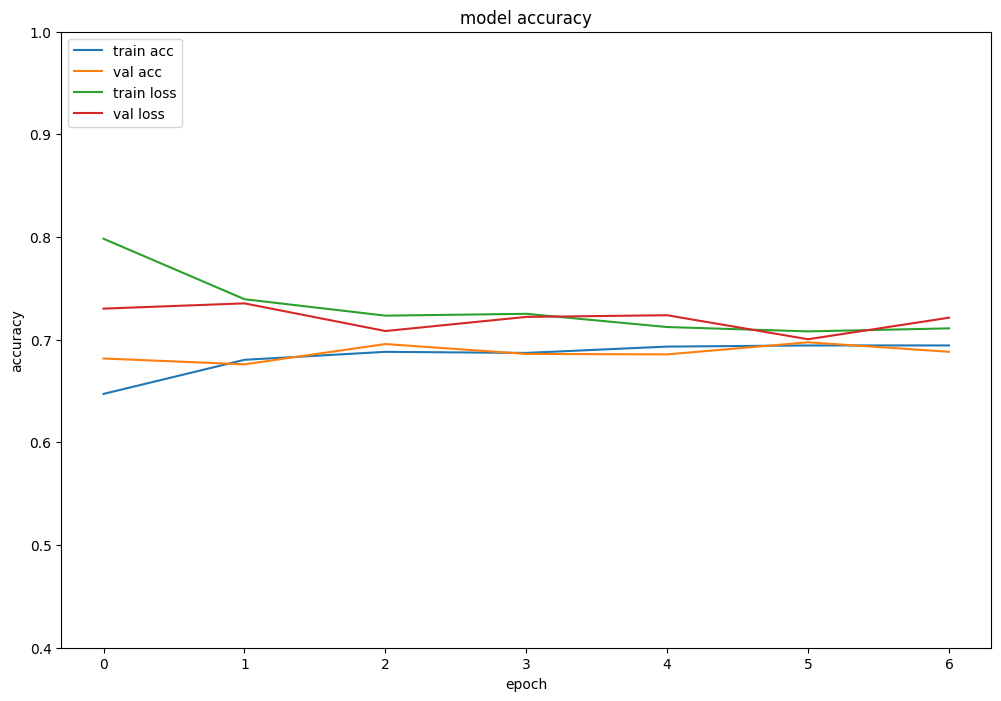

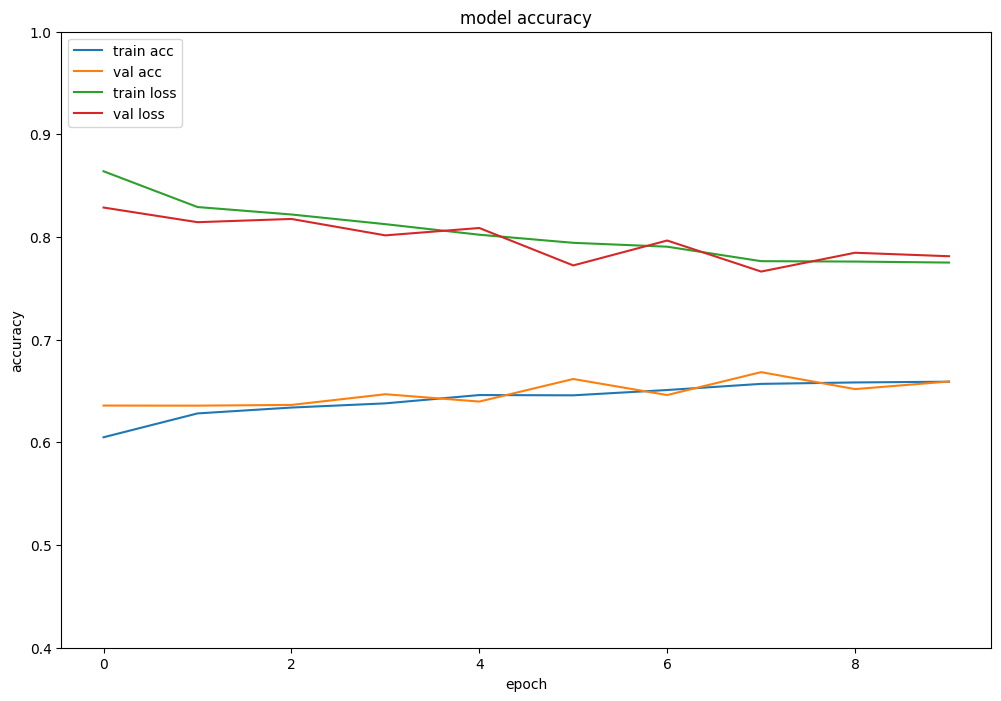

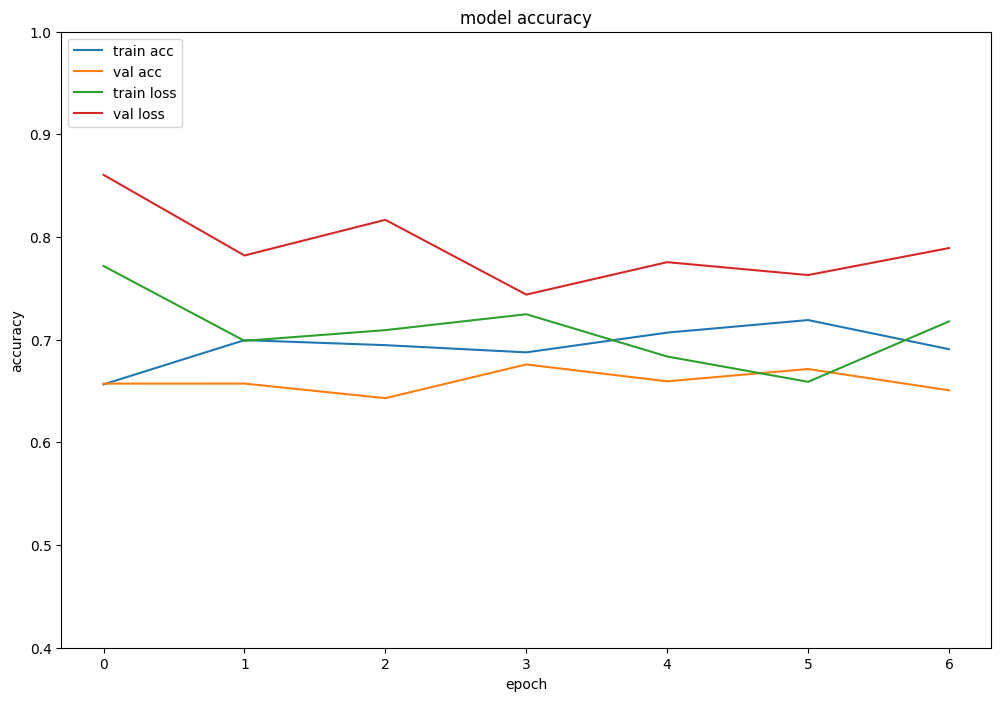

In [37]:
plot_loss_acc(hist)
plot_loss_acc(hist2)
plot_loss_acc(hist3)